<a href="https://colab.research.google.com/github/Dhanush-sai-reddy/uponcv-csv/blob/main/Synapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/Synapse/Synapse_Dataset.zip

Archive:  /content/drive/MyDrive/Synapse/Synapse_Dataset.zip
replace Synapse_Dataset/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from xgboost import XGBClassifier
from scipy.stats import mode


In [ ]:
def rms(x):
    return np.sqrt(np.mean(x**2))

def mav(x):
    return np.mean(np.abs(x))

def wl(x):
    return np.sum(np.abs(np.diff(x)))

def zero_crossing(x, threshold=0.01):
    x1, x2 = x[:-1], x[1:]
    return np.sum((x1 * x2 < 0) & (np.abs(x1 - x2) >= threshold))

def slope_sign_change(x, threshold=0.01):
    x1, x2, x3 = x[:-2], x[1:-1], x[2:]
    return np.sum(
        ((x2 - x1) * (x2 - x3) > 0) &
        ((np.abs(x2 - x1) >= threshold) |
         (np.abs(x2 - x3) >= threshold))
    )


In [ ]:
def inter_channel_correlation(window):
    feats = []
    for i, j in combinations(range(window.shape[1]), 2):
        corr = np.corrcoef(window[:, i], window[:, j])[0, 1]
        if np.isnan(corr):
            corr = 0.0
        feats.append(corr)
    return feats

def rms_ratios(window):
    rms_vals = np.sqrt(np.mean(window**2, axis=0))
    total = np.sum(rms_vals) + 1e-8
    return list(rms_vals / total)


In [ ]:
def extract_window_features_from_csv(
    csv_path,
    window_size=256,
    step_size=128
):
    df = pd.read_csv(csv_path)
    df = df.select_dtypes(include=[np.number])

    if df.shape[1] > 8:
        df = df.iloc[:, -8:]

    data = df.to_numpy(dtype=np.float64)

    window_features = []

    for start in range(0, data.shape[0] - window_size + 1, step_size):
        w = data[start:start + window_size, :]

        feats = []

        # ---- Single-channel features (40) ----
        for ch in range(8):
            sig = w[:, ch]
            feats.extend([
                rms(sig),
                mav(sig),
                wl(sig),
                zero_crossing(sig),
                slope_sign_change(sig)
            ])

        # ---- Inter-channel features ----
        feats.extend(inter_channel_correlation(w))  # 28
        #feats.extend(rms_ratios(w))                  # 8
        #feats.extend(rms_differences(w))             # 28

        window_features.append(feats)

    return np.array(window_features)  # (num_windows, 104)


In [ ]:
def load_dataset_windows(root_dir):
    X, y, trial_ids, subjects = [], [], [], []
    trial_counter = 0

    for session_name in os.listdir(root_dir):
        session_path = os.path.join(root_dir, session_name)
        if not os.path.isdir(session_path):
            continue

        for subject_name in os.listdir(session_path):
            subject_path = os.path.join(session_path, subject_name)
            if not os.path.isdir(subject_path):
                continue

            subject_id = int(subject_name.split("_")[-1])

            for file in os.listdir(subject_path):
                if not file.endswith(".csv"):
                    continue

                gesture_id = int(file.split("_")[0].replace("gesture", ""))
                csv_path = os.path.join(subject_path, file)

                win_feats = extract_window_features_from_csv(csv_path)

                for wf in win_feats:
                    X.append(wf)
                    y.append(gesture_id)
                    trial_ids.append(trial_counter)
                    subjects.append(subject_id)

                trial_counter += 1

    return (
        np.array(X),
        np.array(y),
        np.array(trial_ids),
        np.array(subjects)
    )


In [ ]:
ROOT_DIR = "/content/Synapse_Dataset"

X, y, trial_ids, subjects = load_dataset_windows(ROOT_DIR)

print(X.shape)   # (num_windows, 40)


(49875, 68)


In [ ]:
NUM_CHANNELS = 8
SINGLE_FEATS_PER_CH = 5

NUM_SINGLE = NUM_CHANNELS * SINGLE_FEATS_PER_CH  # 40
NUM_MULTI  = int(NUM_CHANNELS * (NUM_CHANNELS - 1) / 2)  # 28

single_idx = np.arange(0, NUM_SINGLE)
multi_idx  = np.arange(NUM_SINGLE, NUM_SINGLE + NUM_MULTI)
# ----- Feature name construction -----
single_feat_names = []
for ch in range(NUM_CHANNELS):
    single_feat_names.extend([
        f"CH{ch+1}_RMS",
        f"CH{ch+1}_MAV",
        f"CH{ch+1}_WL",
        f"CH{ch+1}_ZC",
        f"CH{ch+1}_SSC",
    ])

multi_feat_names = []
for i, j in combinations(range(NUM_CHANNELS), 2):
    multi_feat_names.append(f"CORR_CH{i+1}_CH{j+1}")

feature_names = single_feat_names + multi_feat_names
feature_names = np.array(feature_names)



In [ ]:
def subject_wise_normalization(X, subjects):
    Xn = np.zeros_like(X)

    for s in np.unique(subjects):
        idx = subjects == s
        mu = X[idx].mean(axis=0)
        std = X[idx].std(axis=0)
        std[std == 0] = 1.0
        Xn[idx] = (X[idx] - mu) / std

    return Xn

X = subject_wise_normalization(X, subjects)


In [ ]:
train_subjects = np.arange(1, 21)
test_subjects  = np.arange(21, 26)

train_idx = np.isin(subjects, train_subjects)
test_idx  = np.isin(subjects, test_subjects)

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
trial_test = trial_ids[test_idx]


In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)

In [ ]:
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=5,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_class=5, ...)

In [ ]:
rf_probs  = rf.predict_proba(X_test)
xgb_probs = xgb.predict_proba(X_test)

rf_conf  = rf_probs.max(axis=1)
xgb_conf = xgb_probs.max(axis=1)

y_pred_windows = []

for i in range(len(X_test)):
    if rf_conf[i] >= xgb_conf[i]:
        y_pred_windows.append(np.argmax(rf_probs[i]))
    else:
        y_pred_windows.append(np.argmax(xgb_probs[i]))

y_pred_windows = np.array(y_pred_windows)


In [ ]:
y_true_trials = []
y_pred_trials = []

for t in np.unique(trial_test):
    idx = trial_test == t

    y_true_trials.append(
        mode(y_test[idx], keepdims=False).mode
    )
    y_pred_trials.append(
        mode(y_pred_windows[idx], keepdims=False).mode
    )


In [ ]:
acc = accuracy_score(y_true_trials, y_pred_trials)
cm  = confusion_matrix(y_true_trials, y_pred_trials)

print("Ensemble Trial Accuracy:", acc)
print("Confusion Matrix:\n", cm)


Ensemble Trial Accuracy: 0.84
Confusion Matrix:
 [[ 83   0   0  22   0]
 [  4  84  16   1   0]
 [  1  26  78   0   0]
 [  8   2   4  91   0]
 [  0   0   0   0 105]]


In [ ]:
rf_importance = rf.feature_importances_
xgb_importance = xgb.feature_importances_
combined_importance = (
    0.5 * rf_importance +
    0.5 * xgb_importance
)
multi_importance = combined_importance[multi_idx]

# Sort multi-channel features by importance (descending)
sorted_multi = multi_idx[np.argsort(multi_importance)[::-1]]

In [ ]:
sorted_vals = np.sort(multi_importance)[::-1]
cum_importance = np.cumsum(sorted_vals) / np.sum(sorted_vals)

K = np.searchsorted(cum_importance, 0.90) + 1  # keep 90% info
selected_multi = sorted_multi[:K]

selected_features = np.concatenate([single_idx, selected_multi])
selected_multi_importance = combined_importance[selected_multi]

df_selected = pd.DataFrame({
    "Feature": selected_multi_names,
    "Importance": selected_multi_importance
}).sort_values("Importance", ascending=False)

df_selected


,Feature,Importance
0,CORR_CH5_CH8,0.060518
1,CORR_CH5_CH7,0.043709
2,CORR_CH1_CH2,0.029021
3,CORR_CH4_CH7,0.024736
4,CORR_CH2_CH3,0.023366
5,CORR_CH1_CH5,0.021950
6,CORR_CH2_CH8,0.021808
7,CORR_CH4_CH5,0.017879
8,CORR_CH3_CH4,0.017067
9,CORR_CH4_CH6,0.016007


In [ ]:
X_train_sel = X_train[:, selected_features]
X_test_sel  = X_test[:, selected_features]


In [ ]:
rf_sel = RandomForestClassifier(
    n_estimators=300,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_sel.fit(X_train_sel, y_train)

xgb_sel = XGBClassifier(
    objective="multi:softprob",
    num_class=5,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

xgb_sel.fit(X_train_sel, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_class=5, ...)

In [ ]:
rf_probs  = rf_sel.predict_proba(X_test_sel)
xgb_probs = xgb_sel.predict_proba(X_test_sel)

rf_conf  = rf_probs.max(axis=1)
xgb_conf = xgb_probs.max(axis=1)

y_pred_windows = []

for i in range(len(X_test)):
    if rf_conf[i] >= xgb_conf[i]:
        y_pred_windows.append(np.argmax(rf_probs[i]))
    else:
        y_pred_windows.append(np.argmax(xgb_probs[i]))

y_pred_windows = np.array(y_pred_windows)


In [ ]:
y_true_trials = []
y_pred_trials = []

for t in np.unique(trial_test):
    idx = trial_test == t

    y_true_trials.append(
        mode(y_test[idx], keepdims=False).mode
    )
    y_pred_trials.append(
        mode(y_pred_windows[idx], keepdims=False).mode
    )


In [ ]:
acc = accuracy_score(y_true_trials, y_pred_trials)
cm  = confusion_matrix(y_true_trials, y_pred_trials)

print("Ensemble Trial Accuracy:", acc)
print("Confusion Matrix:\n", cm)


Ensemble Trial Accuracy: 0.8342857142857143
Confusion Matrix:
 [[ 82   0   0  23   0]
 [  4  85  16   0   0]
 [  1  26  78   0   0]
 [ 10   3   3  89   0]
 [  0   1   0   0 104]]


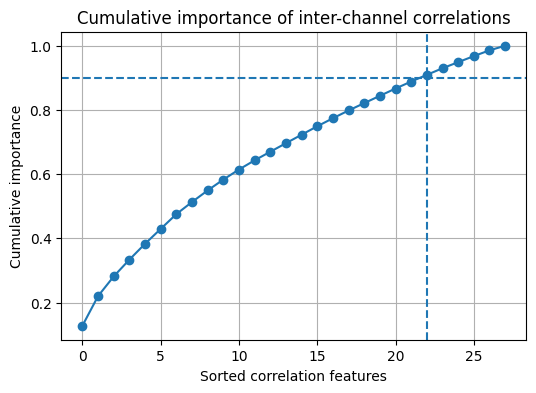

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(cum_importance, marker='o')
plt.axhline(0.9, linestyle='--')
plt.axvline(K-1, linestyle='--')
plt.xlabel("Sorted correlation features")
plt.ylabel("Cumulative importance")
plt.title("Cumulative importance of inter-channel correlations")
plt.grid(True)
plt.show()


In [ ]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score

seeds = [0, 1, 2, 3, 4]
accs = []

for seed in seeds:
    rf_sel = RandomForestClassifier(
        n_estimators=300,
        max_features="sqrt",
        class_weight="balanced",
        random_state=seed,
        n_jobs=-1
    )

    xgb_sel = XGBClassifier(
        objective="multi:softprob",
        num_class=5,
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        random_state=seed,
        n_jobs=-1,
        tree_method="hist"
    )

    rf_sel.fit(X_train_sel, y_train)
    xgb_sel.fit(X_train_sel, y_train)

    # ---- inference ----
    rf_probs  = rf_sel.predict_proba(X_test_sel)
    xgb_probs = xgb_sel.predict_proba(X_test_sel)

    rf_conf  = rf_probs.max(axis=1)
    xgb_conf = xgb_probs.max(axis=1)

    y_pred_windows = []
    for i in range(len(X_test_sel)):
        if rf_conf[i] >= xgb_conf[i]:
            y_pred_windows.append(np.argmax(rf_probs[i]))
        else:
            y_pred_windows.append(np.argmax(xgb_probs[i]))

    y_pred_windows = np.array(y_pred_windows)

    y_true_trials = []
    y_pred_trials = []

    for t in np.unique(trial_test):
        idx = trial_test == t
        y_true_trials.append(mode(y_test[idx], keepdims=False).mode)
        y_pred_trials.append(mode(y_pred_windows[idx], keepdims=False).mode)

    acc = accuracy_score(y_true_trials, y_pred_trials)
    accs.append(acc)

print("Accuracies:", accs)
print("Mean acc:", np.mean(accs))
print("Std acc :", np.std(accs))


Accuracies: [0.8438095238095238, 0.8457142857142858, 0.8495238095238096, 0.8419047619047619, 0.8342857142857143]
Mean acc: 0.8430476190476192
Std acc : 0.005053904442446334


In [ ]:

print("Mean acc:", np.mean(accs))
print("Std acc :", np.std(accs))


Mean acc: 0.8430476190476192
Std acc : 0.005053904442446334
